# 可选实验室——Softmax函数

在本实验中，我们将探索Softmax函数。在解决多类分类问题时，该函数可用于Softmax回归和神经网络。

<center>  
    <img src="../../images/C2_W2_Softmax_Header.PNG" width="600" />     
<center/>

In [17]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.datasets import make_blobs
%matplotlib widget
from lab_utils_softmax import plt_softmax
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config, )

> **注意**：通常，在本课程中，笔记本使用从0开始计数并以N-1结束的约定，$\sum_{i=0}^{N-1}$，而讲座则以1并以N结尾，$\sum_{i=1}^{N}$。这是因为在讲座中，代码通常会从0开始迭代，从1数到N会得到更清晰、更简洁的方程。该笔记本的方程式比实验室中典型的方程式还要多，因此将打破惯例，从1数到N。

## Softmax函数

在Softmax回归和具有Softmax输出的神经网络中，都会生成N个输出，并选择一个输出作为预测类别。在这两种情况下，向量$\mathbf{z}$都是由应用于softmax函数的线性函数生成的。softmax函数将$\mathbf{z}$转换为概率分布，如下所述。应用softmax后，每个输出将在0和1之间，并且输出将加1，以便它们可以被解释为概率。较大的输入将对应较大的输出概率。

<img src="../../images/C2_W2_SoftmaxReg_NN.png" width="600"/>  

softmax函数可以写成：

$$a_j=\frac{e^{z_j}}{\sum_{k=1}^{N}{e^{z_k}}}\tag{1}$$

输出$\mathbf{a}$是长度为N的向量，因此对于softmax回归，您还可以编写：

\begin{align}
\mathbf{a}(x)=
\begin{bmatrix}
P(y=1|\mathbf{x}; mathbf{w},b)\\
\vdots\\
P(y=N|\mathbf{x};\mathbf{w},b)
\end{bmatrix}
=
\frac{1}{\sum_{k=1}^{N}{e^{z_k}}}
\begin{bmatrix}
e^{z_1}\\
\vdots\\
e^{z_{N}}\\
\end{bmatrix}\tag{2}
\end{align}

这表明输出是概率向量。第一项是给定输入$\mathbf{x}$和参数$\mathbf{w}$和$\mathbf{b}$的情况下输入是第一个类别的概率。

让我们创建一个NumPy实现：

In [18]:
def my_softmax(z):
    ez = np.exp(z)
    sm = ez / np.sum(ez)
    return sm

下面，使用滑块改变`z`输入的值。

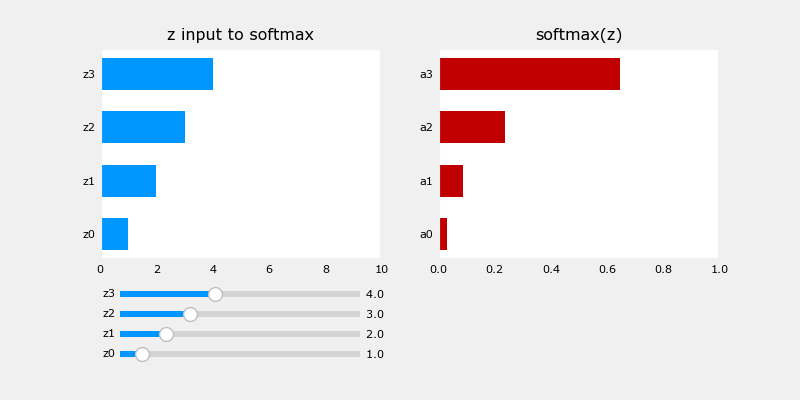

In [19]:
plt.close("all")
plt_softmax(my_softmax)

当您改变上面z的值时，需要注意以下几点：

* softmax分子中的指数放大了值中的微小差异
* 输出值总和为一
* softmax涵盖所有输出。例如，`z0`的更改将更改`a0`-`a3`的值。将此与具有单个输入和单个输出的其他激活（例如ReLu或Sigmoid）进行比较。

## 代价

<center>
    <img src="../../images/C2_W2_SoftMaxCost.png" width="400" />
<center/>

与Softmax相关的损失函数（交叉熵损失）为：

\begin{equation}
    L(\mathbf{a},y)=\begin{cases}
        -log(a_1),&\text{if $y=1$}.\\
        &\vdots\\
        -log(a_N),&\text{if $y=N$}
    \end{cases}\tag{3}
\end{equation}

其中y是本例的目标类别，$\mathbf{a}$是softmax函数的输出。特别是，$\mathbf{a}$中的值是总和为1的概率。

>**回想一下：** 在本课程中，损失只是一个示例，而成本涵盖了所有示例。

请注意，在上面的（3）中，只有与目标对应的线对损失有贡献，其他线为零。为了编写成本方程，我们需要一个“指标函数”，当索引与目标匹配时，该函数为1，否则为0。

$$
\mathbf{1}\{y == n\}=\begin{cases}
1,&\text{if $y==n$}.\\
0,&\text{otherwise}.
\end{cases}
$$

现在的成本是：

\begin{align}
J(\mathbf{w},b)=-\left[\sum_{i=1}^{m}\sum_{j=1}^{N}1\left\{y^{(i)}==j\right\}\log\frac{e^{z^{(i)}_j}}{\sum_{k=1}^N e^{z^{(i)}_k}}\right]\tag{4}
\end{align}

其中$m$是示例的数量，$N$是输出的数量。这是所有损失的平均值。

## TensorFlow

本实验将讨论在Tensorflow中实现softmax、交叉熵损失的两种方法，即“明显”方法和“首选”方法。前者是最直接的，而后者在数值上更稳定。

我们首先创建一个数据集来训练多类分类模型。

In [20]:
centers = [[-5, 2], [-2, -2], [1, 2], [5, -2]]
X_train, y_train = make_blobs(n_samples=2000, centers=centers, cluster_std=1.0, random_state=30)

### *显而易见的*组织

下面的模型是使用softmax作为最终密集层中的激活来实现的。

损失函数在`compile`指令中单独指定。

损失函数`SparseCategoricalCrossentropy`。上述（3）中描述的损失。在此模型中，softmax发生在最后一层。损失函数接受softmax输出，它是一个概率向量。

In [21]:
model = Sequential([Dense(25, activation='relu'), Dense(15, activation='relu'), Dense(4, activation='softmax')])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(0.001))
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
63/63 [==============================] - 0s 1ms/step - loss: 1.0104
Epoch 2/10
63/63 [==============================] - 0s 1ms/step - loss: 0.4901
Epoch 3/10
63/63 [==============================] - 0s 1ms/step - loss: 0.2527
Epoch 4/10
63/63 [==============================] - 0s 1ms/step - loss: 0.1396
Epoch 5/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0926
Epoch 6/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0718
Epoch 7/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0604
Epoch 8/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0531
Epoch 9/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0481
Epoch 10/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0447


因为softmax被集成到输出层，所以输出是概率向量。

In [22]:
p_nonpreferred = model.predict(X_train)
print(p_nonpreferred[:2])
print("largest value", np.max(p_nonpreferred), "smallest value", np.min(p_nonpreferred))

63/63 [==============================] - 0s 670us/step
[[3.93e-03 2.00e-03 9.71e-01 2.30e-02]
 [9.95e-01 4.70e-03 1.71e-05 3.17e-05]]
largest value 0.99999964 smallest value 8.2005847e-10


### 首选

<img align="Right" src="../../images/C2_W2_softmax_accurate.png" style="width:400px; padding: 10px 20px;">

回想一下讲座中，如果在训练时将softmax和loss结合起来，可以获得更稳定、更准确的结果。这是由此处显示的“首选”组织启用的。

在优选的组织中，最后一层具有线性激活。由于历史原因，这种形式的输出被称为*logits*。损失函数有一个附加参数：`from_logits = True`。这告知损失函数，softmax操作应包含在损失计算中。这允许优化实施。

In [23]:
preferred_model = Sequential(
    [Dense(25, activation='relu'), Dense(15, activation='relu'), Dense(4, activation='linear')])
preferred_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        optimizer=tf.keras.optimizers.Adam(0.001))
preferred_model.fit(X_train, y_train, epochs=10)


Epoch 1/10
63/63 [==============================] - 0s 1ms/step - loss: 1.0806
Epoch 2/10
63/63 [==============================] - 0s 1ms/step - loss: 0.5570
Epoch 3/10
63/63 [==============================] - 0s 1ms/step - loss: 0.2525
Epoch 4/10
63/63 [==============================] - 0s 1ms/step - loss: 0.1241
Epoch 5/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0817
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0629
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0535
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0472
Epoch 9/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0430
Epoch 10/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0394


#### 输出处理

请注意，在首选模型中，输出不是概率，而是范围可以从大负数到大正数。在执行期望概率的预测时，必须通过softmax发送输出。

让我们看看首选模型的输出：

In [24]:
p_preferred = preferred_model.predict(X_train)
print(f"two example output vectors:\n {p_preferred[:2]}")
print("largest value", np.max(p_preferred), "smallest value", np.min(p_preferred))

63/63 [==============================] - 0s 678us/step
two example output vectors:
 [[-3.96 -1.66  3.48 -0.28]
 [ 7.87  2.21 -3.45 -3.13]]
largest value 15.387223 smallest value -10.160844


输出预测不是概率！

如果所需的输出是概率，则输出应由[softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax)处理。

In [25]:
sm_preferred = tf.nn.softmax(p_preferred).numpy()
print(f"two example output vectors:\n {sm_preferred[:2]}")
print("largest value", np.max(sm_preferred), "smallest value", np.min(sm_preferred))

two example output vectors:
 [[5.67e-04 5.70e-03 9.71e-01 2.26e-02]
 [9.97e-01 3.45e-03 1.20e-05 1.66e-05]]
largest value 0.9999999 smallest value 2.402168e-09


要选择最可能的类别，不需要 softmax。可以使用[np.argmax()](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)找到最大输出的索引。

In [26]:
for i in range(5):
    print(f"{p_preferred[i]}, category: {np.argmax(p_preferred[i])}")

[-3.96 -1.66  3.48 -0.28], category: 2
[ 7.87  2.21 -3.45 -3.13], category: 0
[ 5.72  2.05 -2.52 -2.73], category: 0
[-0.76  3.99 -2.57 -1.92], category: 1
[-1.87 -1.28  5.63 -0.77], category: 2


## SparseCategorialCrossentropy或CategoricalCrossEntropy

Tensorflow有两种潜在的目标值格式，损失的选择定义了预期的格式。

- SparseCategorialCrossentropy：期望目标是与索引对应的整数。例如，如果有10个潜在目标值，则y将在0到9之间。
- CategoricalCrossEntropy：期望示例的目标值是one-hot编码的，其中目标索引处的值为1，而其他N-1条目为零。具有10个潜在目标值（其中目标为2）的示例将是[0,0,1,0,0,0,0,0,0,0]。

## 恭喜！

在这个实验室里你

- 更加熟悉softmax函数及其在神经网络中softmax回归和softmax激活中的使用。
- 学习了Tensorflow中的首选模型构建：
    - 最后一层没有激活（与线性激活相同）
    - 稀疏分类交叉熵损失函数
    - 使用from_logits=True
- 认识到与ReLu和Sigmoid不同，softmax跨越多个输出。

## 数值稳定性（可选）

本节讨论一些用于提高数值稳定性的方法。这是针对感兴趣的读者的，根本不是必需的。

### Softmax数值稳定性

softmax的输入是线性层$z_j=\mathbf{w_j}\cdot\mathbf{x}^{(i)}+b$的输出。这些可能是大数字。softmax算法的第一步计算$e^{z_j}$。如果数字太大，可能会导致溢出错误。尝试运行下面的单元格：

In [27]:
for z in [500, 600, 700, 800]:
    ez = np.exp(z)
    zs = "{" + f"{z}" + "}"
    print(f"e^{zs} = {ez:0.2e}")

e^{500} = 1.40e+217
e^{600} = 3.77e+260
e^{700} = 1.01e+304
e^{800} = inf


C:\Users\lvzhi\AppData\Local\Temp\ipykernel_52120\168153476.py:2: RuntimeWarning: overflow encountered in exp
  ez = np.exp(z)


如果指数太大，该运算将产生溢出。当然，`my_softmax()`会产生相同的错误：

In [28]:
z_tmp = np.array([[500, 600, 700, 800]])
my_softmax(z_tmp)

C:\Users\lvzhi\AppData\Local\Temp\ipykernel_52120\2661209973.py:2: RuntimeWarning: overflow encountered in exp
  ez = np.exp(z)
C:\Users\lvzhi\AppData\Local\Temp\ipykernel_52120\2661209973.py:3: RuntimeWarning: invalid value encountered in divide
  sm = ez / np.sum(ez)


array([[ 0.,  0.,  0., nan]])

通过减小指数的大小可以提高数值稳定性。

记起

$$e^{a+b}=e^ae^b$$

如果$b$与$a$的符号相反，则会减小指数的大小。具体来说，如果将softmax乘以一个分数：

$$a_j=\frac{e^{z_j}}{\sum_{i=1}^{N}{e^{z_i}}}\frac{e^{-b}}{{e^{-b}}}$$

指数会减小，softmax的值不会改变。如果$e^b$中的$b$是$z_j$的最大值$max_j(\mathbf{z})$，则指数将减少到其最小值。

$$\begin{align}
a_j&=\frac{e^{z_j}}{\sum_{i=1}^{N}{e^{z_i}}}\frac{e^{-max_j(\mathbf{z})}}{{e^{-max_j(\mathbf{z})}}}\\
&=\frac{e^{z_j-max_j(\mathbf{z})}}{\sum_{i=1}^{N}{e^{z_i-max_j(\mathbf{z})}}} 
\end{align}$$

通常说$C=max_j(\mathbf{z})$因为对于任何常数C，该方程都是正确的。

$$
a_j=\frac{e^{z_j-C}}{\sum_{i=1}^{N}{e^{z_i-C}}}\quad\quad\text{where}\quad C=max_j(\mathbf{z})\tag{5}
$$

如果我们看一下我们的麻烦示例，其中$\mathbf{z}$包含500,600,700,800，$C=max_j(\mathbf{z})=800$：

\begin{align}
\mathbf{a}(x)=
\frac{1}{e^{500-800}+e^{600-800}+e^{700-800}+e^{800-800}}
\begin{bmatrix}
e^{500-800}\\
e^{600-800}\\
e^{700-800}\\
e^{800-800}\\
\end{bmatrix}
=
\begin{bmatrix}
5.15e-131\\
1.38e-87\\
3.7e-44\\
1.0\\
\end{bmatrix}
\end{align}

让我们重写`my_softmax`以提高其数值稳定性。

In [29]:
def my_softmax_ns(z):
    bigz = np.max(z)
    ez = np.exp(z - bigz)
    sm = ez / np.sum(ez)
    return sm

让我们尝试一下并将其与TensorFlow实现进行比较：

In [30]:
z_tmp = np.array([500., 600, 700, 800])
print(tf.nn.softmax(z_tmp).numpy(), "\n", my_softmax_ns(z_tmp))

[5.15e-131 1.38e-087 3.72e-044 1.00e+000] 
 [5.15e-131 1.38e-087 3.72e-044 1.00e+000]


大值不再导致溢出。

### 交叉熵损失数值稳定性

这里重复与Softmax相关的损失函数，即交叉熵损失：

\begin{equation}
    L(\mathbf{a},y)=\begin{cases}
        -log(a_1),&\text{if $y=1$}.\\
            &\vdots\\
        -log(a_N),&\text{if $y=N$}
    \end{cases}
\end{equation}

其中y是本例的目标类别，$\mathbf{a}$是softmax函数的输出。特别是，$\mathbf{a}$中的值是总和为1的概率。

让我们考虑目标为2($y=2$)的情况，然后看看该情况的损失。这将导致损失：

$$L(\mathbf{a})=-log(a_2)$$

回想一下，$a_2$是上述softmax函数的输出，因此可以写成：

$$L(\mathbf{z})=-log\left(\frac{e^{z_2}}{\sum_{i=1}^{N}{e^{z_i}}}\right)\tag{6}$$

这可以优化。然而，为了进行这些优化，softmax和损失必须一起计算，如您在上面看到的“首选”Tensorflow实现中所示。

从上面的（6）开始，y=2情况下的损失：

$log(\frac{a}{b})=log(a)-log(b)$，因此（6）可以重写：

$$L(\mathbf{z})=-\left[log(e^{z_2})-log\sum_{i=1}^{N}{e^{z_i}}\right]\tag{7}$$

第一项可以简化为$z_2$：

$$L(\mathbf{z})=-\left[z_2-log(\sum_{i=1}^{N}{e^{z_i}})\right]=\underbrace{log\sum_{i=1}^{N}{e^{z_i}}}_\text{logsumexp()}-z_2\tag{8}$$

事实证明，上式中的$log\sum_{i=1}^{N}{e^{z_i}}$项非常常用，许多库都有实现。在Tensorflow中，这是tf.math.reduce_logsumexp()。此总和的一个问题是，如果$z_i$很大，总和中的指数可能会溢出。为了解决这个问题，我们可能想像上面那样减去$e^{max_j(\mathbf{z})}$，但这需要一些工作：

$$
\begin{align}
    log\sum_{i=1}^{N}{e^{z_i}}&=log\sum_{i=1}^{N}{e^{(z_i-max_j(\mathbf{z})+max_j(\mathbf{z}))}}\tag{9}\\
                            &=log\sum_{i=1}^{N}{e^{(z_i-max_j(\mathbf{z}))}e^{max_j(\mathbf{z})}}\\
                            &=log(e^{max_j(\mathbf{z})})+log\sum_{i=1}^{N}{e^{(z_i-max_j(\mathbf{z}))}}\\
                            &=max_j(\mathbf{z})+log\sum_{i=1}^{N}{e^{(z_i-max_j(\mathbf{z}))}}
\end{align}
$$

现在，指数溢出的可能性较小。通常说$C=max_j(\mathbf{z})$因为对于任何常数C，该方程都是正确的。我们现在可以写出损失方程：

$$L(\mathbf{z})=C+log(\sum_{i=1}^{N}{e^{z_i-C}})-z_2\;\;\;\text{其中}C=max_j(\mathbf{z})\tag{10}$$

计算上更简单、更稳定的损失版本。以上是目标y=2的示例，但可以推广到任何目标。